# Setup

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell;InteractiveShell.ast_node_interactivity = "all"

import sys
import requests

import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import FormatStrFormatter

from velib.data import Velib
from velib.map import StationMap

velib = Velib()

In [2]:
df = pd.read_csv('Data/2021 10 31 30m.csv')

df.datetime = (pd.to_datetime(df.datetime, format = "%Y-%m-%d %H-%M"))

df = df[df.datetime > np.datetime64('2021-10-15 00:15:00')]
df["velos"] = df.elec + df.meca
df['jour'] = df.datetime.dt.day
df['joursemaine'] = df.datetime.dt.weekday
df['heure'] = df.datetime.dt.hour

df.sample(3)
df.shape, df.datetime.min(), df.datetime.max()

,datetime,stationCode,meca,elec,park,velos,jour,joursemaine,heure
437996,2021-10-21 14:30:00,22601,0,0,22,0,21,3,14
209759,2021-10-18 07:00:00,22012,5,3,16,8,18,0,7
129915,2021-10-17 03:00:00,18004,3,2,6,5,17,6,3


((1143666, 9),
 Timestamp('2021-10-15 06:00:00'),
 Timestamp('2021-10-31 21:30:00'))

In [3]:
stations = velib.get_stations_df()
stations.sample(3)
stations.shape

,station_id,name,lat,lon,capacity,stationCode,rental_methods
638,263732151,Gambetta - Michelet,48.852738,2.429966,33,31018,[CREDITCARD]
71,911767210,Alexandre Parodi - Quai de Valmy,48.879359,2.366596,24,10162,[CREDITCARD]
226,210573120,Hoche - Tilsitt,48.874836,2.297132,33,8057,NaN


(1438, 7)

In [4]:
stations.set_index('stationCode', inplace = True)

In [5]:
stations.index = stations.index.astype(int)

# Home subset

## First, let's have a look at one station, over 2 weeks

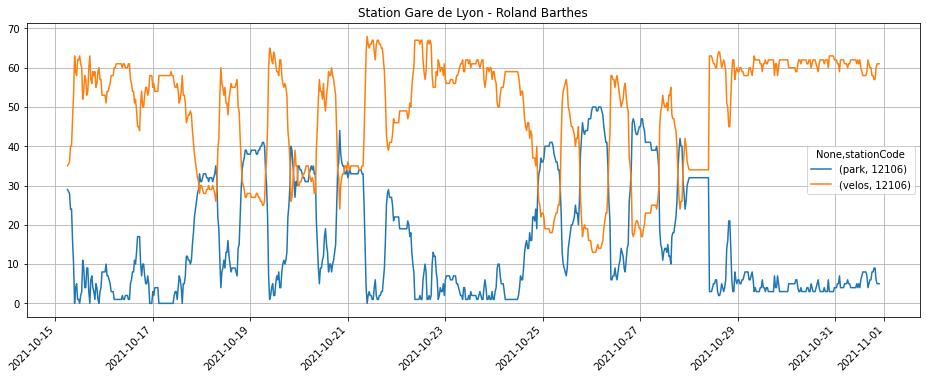

In [6]:
def plot_station(code):
    fig = plt.figure(figsize = (16, 6))
    ax = plt.subplot()

    df[df.stationCode == code].pivot_table(
        values=["velos",'park'], 
        index="datetime", 
        columns="stationCode").plot(ax = ax,
                                   title = f"Station {stations.loc[code,:]['name']}",
                                   xlabel = '')
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45);
    plt.grid();   

plot_station(12106)

In [7]:
map_ = StationMap()
map_.marker([12106], color = "orange", icon = 'bicycle' )
map_.show()

## Let's zoom on one day

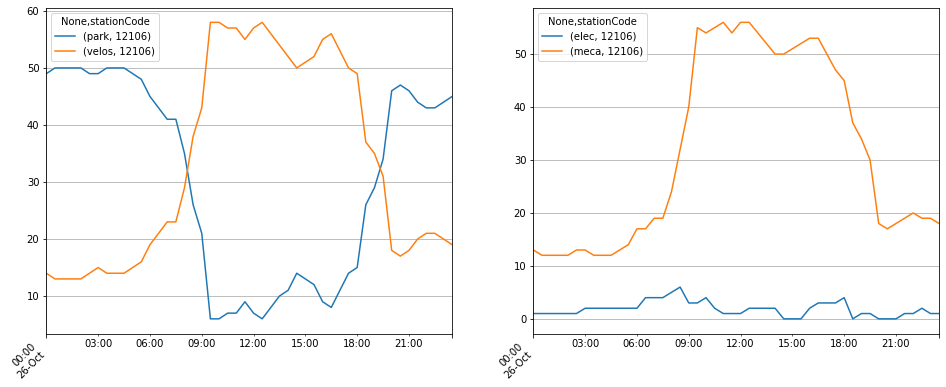

In [8]:
subset = [12106]
df_subset = df.loc[df.stationCode.isin(subset)].loc[df.jour == 26]
fig, axs = plt.subplots(1,2,figsize = (16, 6))
ax1, ax2 = axs.flat

df_subset.pivot_table(
    values=["velos",'park'], 
    index="datetime", 
    columns="stationCode").plot(ax = ax1,
                               title = "",
                               xlabel = '')
plt.setp(ax1.get_xticklabels(), ha="right", rotation=45);
ax1.grid();
df_subset.pivot_table(
    values=["meca",'elec'], 
    index="datetime", 
    columns="stationCode").plot(ax = ax2,
                               title = "",
                               xlabel = '')
plt.setp(ax2.get_xticklabels(), ha="right", rotation=45);
ax2.grid();

## do all nearest station behave the same way?

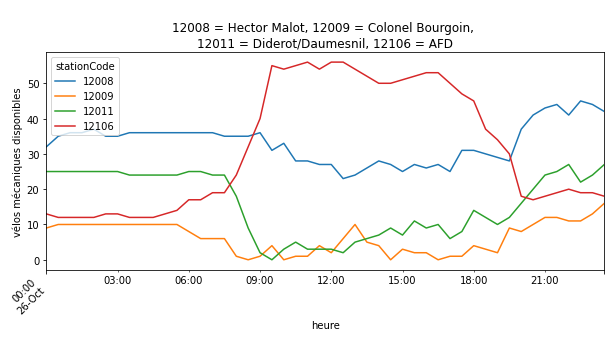

In [9]:
home_stations = [12008, 12009, 12106, 12011,]
df_home = df.loc[df.stationCode.isin(home_stations)].loc[df.jour == 26]
fig = plt.figure(figsize = (10, 4))
ax = plt.subplot()
df_home.pivot_table(
    values="meca", 
    index="datetime", 
    columns="stationCode").plot(xlabel = "heure", 
                                ylabel = 'vélos mécaniques disponibles', 
                                ax = ax,
                                title = """
12008 = Hector Malot, 12009 = Colonel Bourgoin, 
12011 = Diderot/Daumesnil, 12106 = AFD""");
ax = plt.gca()
plt.setp(ax.get_xticklabels(), ha="right", rotation=45);

# plt.savefig("Velib01.png");

In [10]:
map_ = StationMap()
map_.marker(12008, 12009, 12106, 12011,)
map_.show()

# Distribution des moyennes

In [11]:
df_means = df.groupby("stationCode", as_index = False).mean().drop(columns = ["jour", "joursemaine", "heure" ]);df_means.sample(3)
# df_means = df_means.query('total != 0')

,stationCode,meca,elec,park,velos
1366,42701,1.415307,4.855709,23.491844,6.271016
384,11042,13.864492,1.708908,30.120452,15.573400
546,14006,1.691343,1.432873,19.583438,3.124216


In [12]:
params = {
    "velos": {
        "title": "Tous vélos",
        "binwidth": 10,
        "color": 'lightgray',
        "ylim": [0.9, 1200]
    },
    "park": {
        "title": "Places disponibles",
        "binwidth": 10,
        "color": 'mediumorchid',
        "ylim": [0.9, 1200]
    },
    "meca": {
        "title": "Vélos mécaniques",
        "binwidth": 5,
        "color": 'forestgreen',
        "ylim": [0.9, 1200]
    },
    "elec": {
        "title": "Vélos électriques",
        "binwidth": 1,
        "color": 'steelblue',
        "ylim": [0.9, 1200]
    },
    "proportion": {
        "title": "Proportion d'occupation",
        "binwidth": 10,
        "color": 'gold',
        "ylim": [0.9, 1200]
    },
}

In [13]:
from matplotlib.ticker import FormatStrFormatter
def pretty_hist(series, ymax, xrange:tuple, binwidth = None):
    binwidth = binwidth if binwidth else xrange[1]/10
    fig,ax = plt.subplots(1,1,figsize = (12,6))
    ax.grid(zorder=0, axis = "y")
    ax = sns.histplot(series, kde=False, binwidth = binwidth, binrange = xrange, zorder=3, alpha = None)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
    plt.xticks(rotation=45);
    for p in ax.patches:
        label =f'{p.get_height()}'
        width, height =p.get_width(),p.get_height()
        x = p.get_x() + 0.5 * width
        y = p.get_height() + 0.5 * height
        ax.annotate(label,(x,y), va = 'center', ha = 'center', fontsize = 16);
    ax.set_ylim([0.4, ymax])

def format_log_hist(ax, series, **kwargs):
    sns.histplot(series, kde=False, binwidth = kwargs['binwidth'], ax = ax, color = kwargs['color']);
    ax.set_yscale('log');
    ax.yaxis.set_major_formatter(FormatStrFormatter('%d'));
    ax.grid(axis = 'y', linestyle = ':')
    for p in ax.patches:
        label =f'{p.get_height()}'
        width, height =p.get_width(),p.get_height()
        x = p.get_x() + 0.5 * width
        y = p.get_height() + 0.5 * height
        ax.annotate(label,(x,y), va = 'center', ha = 'center');
        ax.spines[['top', 'right']].set_visible(False)
    ax.set_ylim(kwargs['ylim']);
    ax.set_title(kwargs['title'])
    ax.set_xlabel('')
    ax.set_ylabel('')

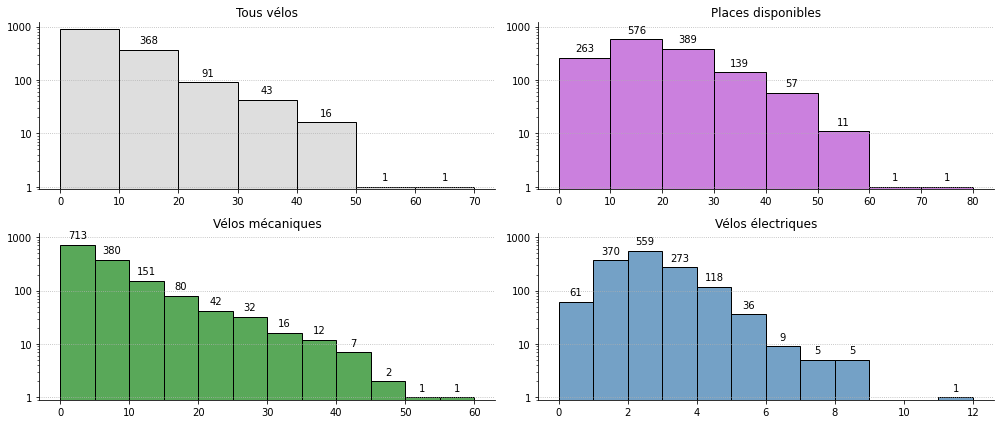

In [14]:
fig,axs = plt.subplots(2,2,figsize = (14,6))
ax1, ax2, ax3, ax4 = axs.flat
format_log_hist(ax1, df_means.velos, **params["velos"])
format_log_hist(ax2, df_means.park, **params["park"])
format_log_hist(ax3, df_means.meca, **params["meca"])
format_log_hist(ax4, df_means.elec, **params["elec"])
fig.tight_layout()
    

In [15]:
# reprendre fonction pretty_hist proportion

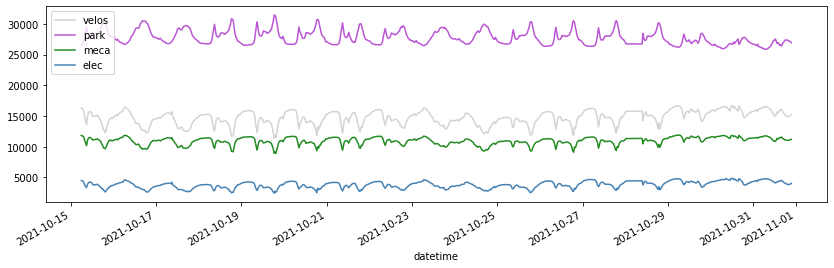

In [16]:
df.groupby("datetime").sum()[["velos", "park", "meca", "elec",]].plot(figsize = (14,4), color = ['lightgray', 'mediumorchid', 'forestgreen', 'steelblue']);

# Groupby weekday

In [17]:
df_weekday = df[df.joursemaine.isin([1,2,3])].groupby(['stationCode', 'heure'], as_index = False).mean().drop(columns = ["jour", "joursemaine"])
df_weekday = df_weekday.set_index(['stationCode', 'heure'])
df_weekday

meca      elec       park      velos
stationCode heure                                          
1001        0      3.333333  0.583333  11.750000   3.916667
            1      2.083333  0.666667  12.916667   2.750000
            2      2.083333  0.500000  13.083333   2.583333
            3      1.666667  0.500000  13.500000   2.166667
            4      1.500000  0.500000  13.666667   2.000000
...                     ...       ...        ...        ...
92008       19     6.833333  5.083333  25.333333  11.916667
            20     6.500000  4.750000  25.666667  11.250000
            21     6.416667  4.666667  25.750000  11.083333
            22     6.416667  4.750000  25.666667  11.166667
            23     6.545455  5.363636  25.000000  11.909091

[34488 rows x 4 columns]

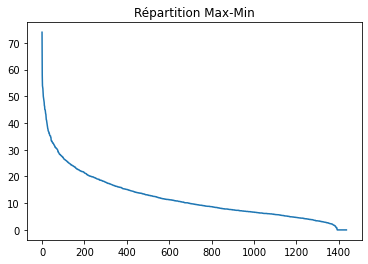

In [18]:
station_order_maxmin = (df_weekday.groupby("stationCode")
             .max().velos 
     - df_weekday.groupby("stationCode")
                 .min().velos).sort_values(ascending = False)
station_order_maxmin.head()
station_order_maxmin.tail()
station_order_maxmin.reset_index(drop = True).plot(title = "Répartition Max-Min");

In [19]:
high_maxmin_list = station_order_maxmin[:50].index.tolist() ; high_maxmin_list[:5]; len(high_maxmin_list)

[8004, 1013, 13055, 15012, 21306]

50

In [21]:
# df_weekday.loc[(:,12),'meca'] - df_weekday.loc[(:,0),'meca']
# # for station in higher_ampl_list:
# #     df.loc[df.stationCode == station,"delta"] = df.loc[(station,12),'meca'] - df.loc[(station,0),'meca'] 
# # df_weekday.sort_values(by = ["amplitude", "heure", "stationCode"], inplace = True, ascending = False)

In [22]:
df_weekday.loc[high_maxmin_list]
# df_weekday.loc[df_weekday.stationCode.isin(high_maxmin_list)]

meca      elec       park      velos
stationCode heure                                           
8004        0       2.083333  1.083333  62.833333   3.166667
            1       1.750000  1.083333  63.166667   2.833333
            2       1.750000  1.166667  63.083333   2.916667
            3       1.833333  1.166667  63.000000   3.000000
            4       1.666667  1.166667  63.166667   2.833333
...                      ...       ...        ...        ...
12106       19     35.083333  1.416667  29.916667  36.500000
            20     29.333333  1.583333  35.416667  30.916667
            21     33.583333  3.500000  29.083333  37.083333
            22     35.583333  4.000000  26.583333  39.583333
            23     33.818182  3.363636  28.636364  37.181818

[1200 rows x 4 columns]

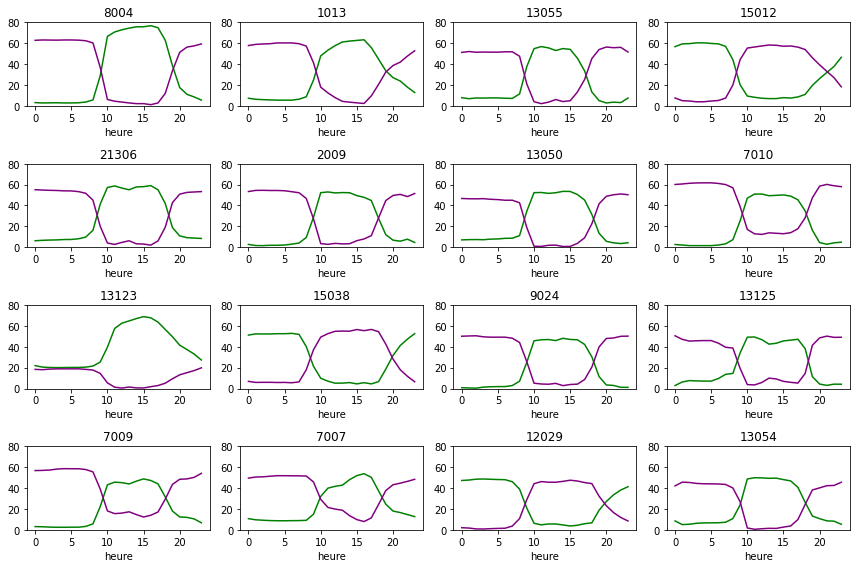

In [23]:
fig, axs = plt.subplots(4,4, figsize = (12,8))
for station, ax in zip(high_maxmin_list, axs.flat):
    df_weekday.loc[station,["velos","park"]].plot(ax=ax, title = str(station), legend = None, color = ['green', 'purple']);
    ax.set_ylim((0,80));
fig.tight_layout();

In [24]:
# for station in df_weekday.index.levels[0]:
#     df_weekday[1001]

In [25]:
df_weekday.loc[1001].loc[12]

meca      5.416667
elec      5.416667
park      5.000000
velos    10.833333
Name: 12, dtype: float64

# Make groups and map stations

In [26]:
summary_df = pd.DataFrame(
    [[station, 
      df_weekday.loc[(station,12), 'velos'] ,
      df_weekday.loc[(station,0), 'velos'],
     ] for station in df_weekday.index.levels[0]], columns = ['stationCode', 'midi', 'minuit']).set_index('stationCode'); 
summary_df["delta"] = summary_df.midi - summary_df.minuit

In [27]:
summary_df

,midi,minuit,delta
stationCode,,,
1001,10.833333,3.916667,6.916667
1002,12.083333,1.583333,10.500000
1003,17.500000,10.416667,7.083333
1006,9.916667,6.333333,3.583333
1007,11.000000,2.916667,8.083333
...,...,...,...
92004,8.250000,2.500000,5.750000
92005,21.916667,17.666667,4.250000
92006,3.333333,1.250000,2.083333


In [28]:
df_weekday

meca      elec       park      velos
stationCode heure                                          
1001        0      3.333333  0.583333  11.750000   3.916667
            1      2.083333  0.666667  12.916667   2.750000
            2      2.083333  0.500000  13.083333   2.583333
            3      1.666667  0.500000  13.500000   2.166667
            4      1.500000  0.500000  13.666667   2.000000
...                     ...       ...        ...        ...
92008       19     6.833333  5.083333  25.333333  11.916667
            20     6.500000  4.750000  25.666667  11.250000
            21     6.416667  4.666667  25.750000  11.083333
            22     6.416667  4.750000  25.666667  11.166667
            23     6.545455  5.363636  25.000000  11.909091

[34488 rows x 4 columns]

In [29]:
# summary_df = pd.DataFrame()
# summary_df.index = df_weekday.index.levels[0];summary_df
# summary_df['midi'] = 
midi_s = pd.Series((df_weekday.loc[(station,15), 'velos'] for station in df_weekday.index.levels[0]), index = df_weekday.index.levels[0])
minuit_s = pd.Series((df_weekday.loc[(station,5), 'velos'] for station in df_weekday.index.levels[0]), index = df_weekday.index.levels[0])
delta_s = midi_s - minuit_s
max_s = df_weekday.groupby("stationCode").max().velos
min_s = df_weekday.groupby("stationCode").min().velos
summary_df = pd.DataFrame({'midi': midi_s,
                          'minuit': minuit_s,
                          'delta': delta_s,
                           'maxi': max_s,
                           'mini': min_s
                          })
# ;summary_df.isnull().sum()
# summary_df['delta'] = pd.Series(df_weekday.loc[(station,12), 'velos'] - df_weekday.loc[(station,0), 'velos'] for station in summary_df.index);*

summary_df

,midi,minuit,delta,maxi,mini
stationCode,,,,,
1001,12.166667,2.000000,10.166667,12.416667,2.000000
1002,12.666667,1.000000,11.666667,13.500000,0.583333
1003,30.916667,5.250000,25.666667,35.250000,4.416667
1006,22.000000,2.666667,19.333333,29.166667,2.666667
1007,10.916667,2.333333,8.583333,11.833333,1.333333
...,...,...,...,...,...
92004,11.750000,2.750000,9.000000,11.750000,2.500000
92005,23.416667,17.333333,6.083333,23.916667,17.166667
92006,3.583333,1.166667,2.416667,4.083333,1.083333


In [30]:
summary_df.sort_values(by = 'delta').shape

(1437, 5)

<AxesSubplot:xlabel='midi', ylabel='minuit'>

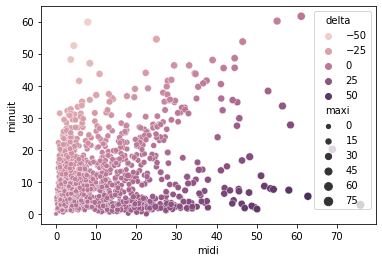

In [31]:
sns.scatterplot(data = summary_df, x='midi',y='minuit', hue='delta', size='maxi')

In [32]:
# group_1 = summary_df.query('delta > 20').index.tolist()
# group_2 = summary_df.query('10 < delta <= 20').index.tolist()
# group_3 = summary_df.query('-10 < delta <= 10').index.tolist()
# group_4 = summary_df.query('-20 < delta <= -10').index.tolist()
# group_5 = summary_df.query('delta <= -20').index.tolist()

group_1 = summary_df.query('delta > 15').index.tolist()
group_2 = summary_df.query('7 < delta <= 15').index.tolist()
group_3 = summary_df.query('-7 < delta <= 7').index.tolist()
group_4 = summary_df.query('-15 < delta <= -7').index.tolist()
group_5 = summary_df.query('delta <= -15').index.tolist()

In [33]:
for group in [group_1, group_2, group_3, group_4, group_5]: print(len(group))

152
133
767
250
135


In [34]:
map_ = StationMap()
# map_.marker(*group_3, color = 'gray')
map_.marker(*group_2, color = "orange", icon = 'briefcase' )
map_.marker(*group_1, color = "red" , icon = 'briefcase' )
map_.marker(*group_4, color = "green", icon = 'home' )
map_.marker(*group_5, color = "blue", icon = 'home' )

map_.show()

In [35]:
import pandas as pd
import requests

URL_VELIB_STATUS = "https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_status.json"
URL_VELIB_STATIONS = "https://velib-metropole-opendata.smoove.pro/opendata/Velib_Metropole/station_information.json"

response = requests.get(URL_VELIB_STATUS)
response.status_code
# velib_df = pd.DataFrame(response.json()["data"]["stations"])
# velib_df

200

In [36]:
df

,datetime,stationCode,meca,elec,park,velos,jour,joursemaine,heure
1432,2021-10-15 06:00:00,16107,2,4,28,6,15,4,6
1433,2021-10-15 06:00:00,11104,8,2,9,10,15,4,6
1434,2021-10-15 06:00:00,9020,1,1,19,2,15,4,6
1435,2021-10-15 06:00:00,12109,24,3,1,27,15,4,6
1436,2021-10-15 06:00:00,5001,0,0,43,0,15,4,6
...,...,...,...,...,...,...,...,...,...
1145093,2021-10-31 21:30:00,15056,16,4,4,20,31,6,21
1145094,2021-10-31 21:30:00,21514,0,0,0,0,31,6,21
1145095,2021-10-31 21:30:00,31301,0,0,0,0,31,6,21
1145096,2021-10-31 21:30:00,31303,0,0,0,0,31,6,21


# Random choices

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (12, 12))
for ax in axs.flat:
    random_list = df.sample(2).stationCode.tolist() 
    (df[df.stationCode.isin(random_list)]
                .pivot_table(
                    values="meca", 
                    index="datetime", 
                    columns="stationCode")
                .plot(ax = ax,))
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45);
fig.tight_layout();
# plt.savefig("Velib_random02.png");

# Big stations 

In [ ]:
df_max = df.groupby("stationCode").max()[["total"]]
big_list = list(df_max.sort_values(by='total', ascending = False).index[:30])
big_list
df.head()

In [ ]:
fig, axs = plt.subplots(5,2, figsize = (12, 12))
for i, ax in enumerate(axs.flat):
    (df[df.stationCode.isin(big_list[3*i:3*i+3])]
                .pivot_table(
                    values="meca", 
                    index="datetime", 
                    columns="stationCode")
                .plot(ax = ax,));
    plt.setp(ax.get_xticklabels(), ha="right", rotation=45);
    ax.spines[['top', 'left', 'bottom', 'right']].set_visible(False)
    ax.set_xlabel('')
    ax.set_xticks([])
fig.tight_layout();
# plt.savefig("Velib_random02.png");

In [ ]:
map_ = StationMap()

In [ ]:
map_.marker(big_list)

In [ ]:
map_.show()

##### df_week = df[df.datetime.dt.weekday <5] # jours de la semaine
df_week['hour'] = df_week.datetime.dt.hour # colonne heure

In [ ]:
fig, axs = plt.subplots(10,10, figsize = (16,16))
for station, ax in zip(random_list, axs.flat):
    df_week.groupby(['stationCode', 'hour']).mean().loc[station,:].plot(ax=ax, title = str(station), legend = None)
fig.tight_layout()

In [ ]:
df = df.set_index(['datetime', 'stationCode']).droplevel(0)

In [ ]:
df.index.unique()

In [ ]:
df.query('stationCode in (np.random.choice(df.stationCode.unique(), 100))')

In [ ]:

stations_random = np.random.choice(df.stationCode.unique(), 100)
df = df[df.stationCode.isin(stations_random)]
df = df[df.datetime.dt.weekday <5] # jours de la semaine
df['hour'] = df.datetime.dt.hour # colonne heure
df = df.groupby(['stationCode', 'hour']).mean()

In [ ]:
df.droplevel(1).index

In [ ]:
df

In [ ]:
df = df.copy()
df = df[df.datetime.dt.weekday <5] # jours de la semaine
df['hour'] = df.datetime.dt.hour # colonne heure
df = df.groupby(['stationCode', 'hour']).mean()
for station in df.index.droplevel(1).unique():
    df.loc[station,"amplitude"] = df.loc[station,:].max().meca - df.loc[station,:].min().meca 
df.sort_values(by = ["amplitude", "hour", "stationCode"], inplace = True, ascending = False)


def display(self = df):
    df = self.copy()
#     np.random.seed(0)
#     stations_random = np.random.choice(df.stationCode.unique(), 100, replace = False)
#     df = df[df.stationCode.isin(stations_random)]
    df = df[df.datetime.dt.weekday <5] # jours de la semaine
    df['hour'] = df.datetime.dt.hour # colonne heure
    
    fig, axs = plt.subplots(10,10, figsize = (16,16))
    df = df.groupby(['stationCode', 'hour']).mean()
    for station in df.index.droplevel(1).unique():
        df.loc[station,"amplitude"] = df.loc[station,:].max().meca - df.loc[station,:].min().meca 
    df.sort_values(by = ["amplitude", "hour", "stationCode"], inplace = True, ascending = False)
    print(df)

    for station, ax in zip(df.index.droplevel(1).unique(),axs.flat):
        ax.plot(df.loc[station, 'meca'], 'green', df.loc[station, 'park'], 'purple')
        ax.set_title(str(station), y = -0.2)
#         df.loc[station,['meca', 'park']].plot(ax=ax, title = str(station), legend = None)
        ax.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
        ax.set_axis_off()
        ax.set_ylim([0,65])
    fig.tight_layout()
# display()

In [ ]:
df.index.droplevel(1).unique()

In [ ]:
higher_ampl_list = df.index.droplevel(1).unique()[:100].tolist()

In [ ]:
df_high = df.loc[higher_ampl_list,:]

In [ ]:
df_type1 = df.query('delta >= 20').index.droplevel(1).unique().tolist()
df_type2 = df.query('delta < -20').index.droplevel(1).unique().tolist()

In [ ]:
df_type3 = df.query('10 <= delta < 20').index.droplevel(1).unique().tolist()
df_type4 = df.query('-20<= delta < -10').index.droplevel(1).unique().tolist()

In [ ]:
len(df_type2)

In [ ]:
for station in higher_ampl_list:
    df.loc[station,"delta"] = df.loc[(station,12),'meca']-df.loc[(station,0),'meca'] 

In [ ]:
map_ = StationMap()

map_.marker(*df_type1, color = "red" )
map_.marker(*df_type2, color = "green" )
map_.marker(*df_type3, color = "orange" )
map_.marker(*df_type4, color = "blue" )

map_.show()

In [ ]:
fig, axs = plt.subplots(4,4, figsize = (12,8))
for station, ax in zip(df_type1, axs.flat):
    df.groupby(['stationCode', 'hour']).mean().loc[station,["meca","park"]].plot(ax=ax, title = str(station), legend = None, color = ['green', 'purple'])
    ax.set_ylim({0,65})
fig.tight_layout()

In [ ]:
fig, axs = plt.subplots(4,4, figsize = (12,8))
for station, ax in zip(df_type2, axs.flat):
    df.groupby(['stationCode', 'hour']).mean().loc[station,["meca","park"]].plot(ax=ax, title = str(station), legend = None, color = ['green', 'purple'])
    ax.set_ylim({0,65})
fig.tight_layout()

In [ ]:
import dotsi

params_dotsi = dotsi.Dict(params)

In [ ]:
params_dotsi.meca.title